# Link Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive

/content/drive/My Drive


# Clone the Darknet

We will first make some changes to the Makefile before we compile. Specifically, we will enable the following:

* Build darknet with OpenCV
* Build with CUDA enabled
* Build with cuDNN enabled.

In [ ]:
!git clone https://github.com/AlexeyAB/darknet.git

In [ ]:
%cd darknet

/content/drive/My Drive/darknet


In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

print("Building. . . It might take 2-3 minutes")

!make &> build_log.txt

Building. . . It might take 2-3 minutes


# Prepare Dataset

In [ ]:
import random
import os
import subprocess
import sys

image_dir = "/content/drive/MyDrive/mask_no-mask_dataset"
f_val = open("data_test.txt", 'w')
f_train = open("data_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = len(files)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

for f in os.listdir(image_dir):
    if(f.split(".")[-1] == "jpg"):
        ind += 1
        
        if ind in test_array:
            f_val.write(image_dir+'/'+f+'\n')
        else:
            f_train.write(image_dir+'/'+f+'\n')

f_train.close()
f_val.close()

#  Download Code for YOLO Training

In [ ]:
!wget "https://www.dropbox.com/sh/jfyj1wetf28bgpr/AACGJHIlPyKRO70B9DlAVqWPa?dl=1" -O yolov3-ambulance-code.zip
!unzip -o yolov3-ambulance-code.zip

--2023-01-26 07:07:32--  https://www.dropbox.com/sh/jfyj1wetf28bgpr/AACGJHIlPyKRO70B9DlAVqWPa?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/dl/jfyj1wetf28bgpr/AACGJHIlPyKRO70B9DlAVqWPa [following]
--2023-01-26 07:07:34--  https://www.dropbox.com/sh/dl/jfyj1wetf28bgpr/AACGJHIlPyKRO70B9DlAVqWPa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc727f7de956642534202bc3577a.dl.dropboxusercontent.com/zip_download_get/BYr5EdHxbJ6fo9NfOB74QytN3QX_NsJ05nbY9ChnA6SjY8J5eNosgSMv5vxLOfChhbKoAkevyhL2gcV-zr03xEfUVvhY86Kmkh-nmGCmogUknA?dl=1# [following]
--2023-01-26 07:07:34--  https://uc727f7de956642534202bc3577a.dl.dropboxusercontent.com/zip_download_get/BYr5EdHxbJ6fo9NfOB74QytN3QX_NsJ05nbY9ChnA6SjY8J5eNosgSMv5vxLOfChhbKoAkevyhL2gcV-zr03xE

# Download weights for Convolutional backbone

In [ ]:
!wget "https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1" -O darknet53.conv.74

--2023-01-26 07:07:59--  https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/18dwbfth7prbf0h/darknet53.conv.74 [following]
--2023-01-26 07:08:01--  https://www.dropbox.com/s/dl/18dwbfth7prbf0h/darknet53.conv.74
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc08c251a547a8ab4416ddd037be.dl.dropboxusercontent.com/cd/0/get/B1T-nZsqzOrD67BKvHM6-LijlT2RMzth85Ctp1O5IlQ754PpmDs8cWCO37Bn7JbGZbXrVrHnG8R50LbSF1ytm-AUvtpBSpgRy7IQH4aDFMGbxDkkqtME1uNkJanvHKotyEkwV95W7pg4UsGY8W0S7lsRNsGTmOnP1d9a64PCCiLCMhZJS4uHrU01jVXi0Z3-Dyg/file?dl=1# [following]
--2023-01-26 07:08:01--  https://uc08c251a547a8ab4416ddd037be.dl.dropboxusercontent.com/cd/0/get/B1T-nZsqzOrD67BKvHM6-LijlT2RMzth85Ctp1O

# Training Configuration
 * Set yolov3-ambulance-setup.data classes = 2
 * class.names = mask, no_mask
 * yolov3-ambulance-train.cfg change filters from 18 to 21 and classes from 1 to 2
  - line 610, 612, 691, 697, 776, 782
 * yolov3-ambulance-test.cfg change filters from 18 to 21 and classes from 1 to 2
  - line 606, 612, 691, 697, 776, 782

In [ ]:
!./darknet detector train yolov3-ambulance-setup.data yolov3-ambulance-train.cfg ./darknet53.conv.74 -dont_show -map 2> train_log.txt

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def display_output(imagePath):
    src = cv2.imread(imagePath,1)
    output = cv2.imread("predictions.jpg")

    plt.figure(figsize=[20,8])
    plt.subplot(121)
    plt.imshow(src[:,:,::-1])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(output[:,:,::-1])
    plt.title("Predictions")
    plt.show()

# Test image 1

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 236 K-images (3 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
/content/drive/MyDrive/darknet/test-image1.jpg: Predicted in 6.936000 milli-seconds.
mask: 100%


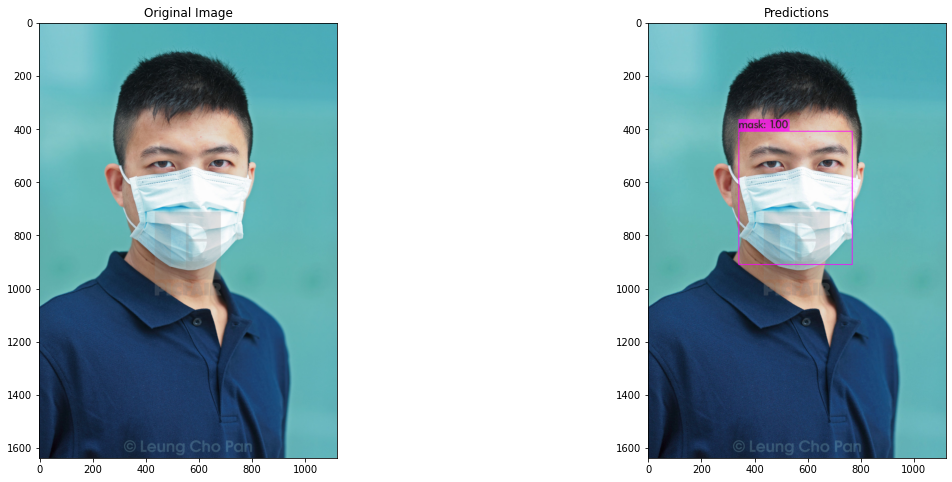

In [ ]:
!./darknet detector test yolov3-ambulance-setup.data yolov3-ambulance-test.cfg backup/yolov3-ambulance-train_best.weights /content/drive/MyDrive/darknet/test-image1.jpg -thresh .3 2> /dev/null
display_output("/content/drive/MyDrive/darknet/test-image1.jpg")

# Test image 2

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 236 K-images (3 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
/content/drive/MyDrive/darknet/test-image2.jpg: Predicted in 6.829000 milli-seconds.
mask: 99%
mask: 73%
mask: 54%
no_mask: 95%
mask: 42%


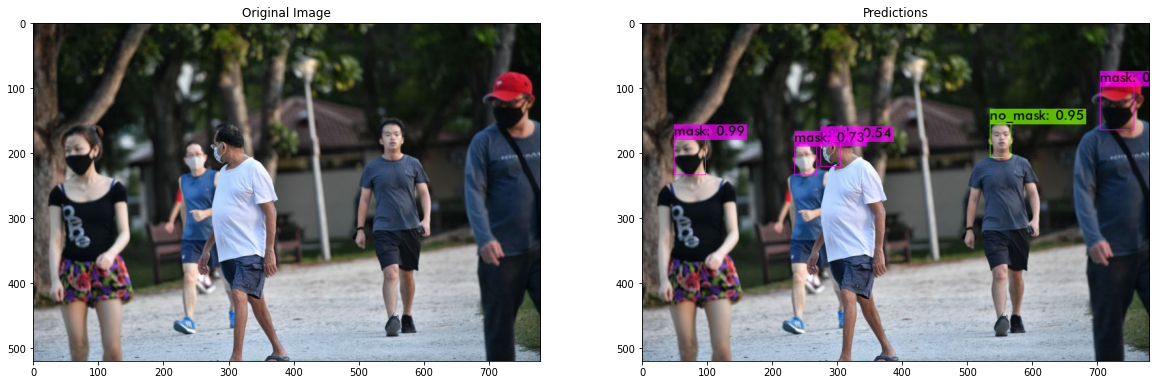

In [ ]:
!./darknet detector test yolov3-ambulance-setup.data yolov3-ambulance-test.cfg backup/yolov3-ambulance-train_best.weights /content/drive/MyDrive/darknet/test-image2.jpg -thresh .3 2> /dev/null
display_output("/content/drive/MyDrive/darknet/test-image2.jpg")

# Test image 3

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 236 K-images (3 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
/content/drive/MyDrive/darknet/test-image3.jpg: Predicted in 7.296000 milli-seconds.
mask: 100%
mask: 100%
no_mask: 88%
mask: 100%
mask: 99%
mask: 99%
mask: 100%
mask: 95%
mask: 100%
mask: 100%
mask: 100%
mask: 100%
mask: 98%
mask: 100%
mask: 100%
mask: 100%
mask: 100%


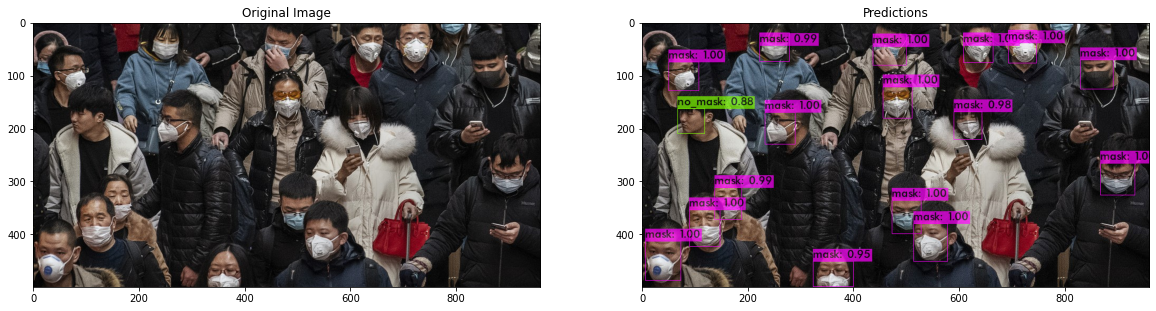

In [ ]:
!./darknet detector test yolov3-ambulance-setup.data yolov3-ambulance-test.cfg backup/yolov3-ambulance-train_best.weights /content/drive/MyDrive/darknet/test-image3.jpg -thresh .3 2> /dev/null
display_output("/content/drive/MyDrive/darknet/test-image3.jpg")

# Test image 4

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 236 K-images (3 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
/content/drive/MyDrive/darknet/test-image4.jpg: Predicted in 6.956000 milli-seconds.
no_mask: 83%
no_mask: 51%
mask: 96%
mask: 100%
no_mask: 75%
mask: 96%
mask: 32%
mask: 100%


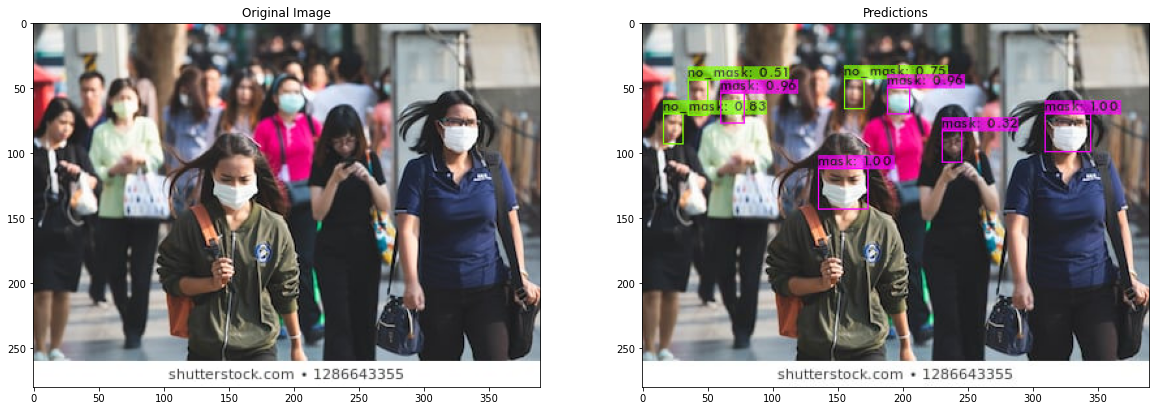

In [ ]:
!./darknet detector test yolov3-ambulance-setup.data yolov3-ambulance-test.cfg backup/yolov3-ambulance-train_best.weights /content/drive/MyDrive/darknet/test-image4.jpg -thresh .3 2> /dev/null
display_output("/content/drive/MyDrive/darknet/test-image4.jpg")

# Test Video 1

In [ ]:
!./darknet detector demo yolov3-ambulance-setup.data yolov3-ambulance-test.cfg backup/yolov3-ambulance-train_best.weights /content/drive/MyDrive/darknet/test-video1.mp4 -thresh .3 -out_filename out-vid1.avi -dont_show

Streaming output truncated to the last 5000 lines.
no_mask: 100% 
no_mask: 93% 
no_mask: 80% 
mask: 99% 
mask: 99% 
mask: 64% 

FPS:107.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

no_mask: 100% 
no_mask: 75% 
no_mask: 50% 
mask: 100% 
mask: 99% 
mask: 91% 

FPS:109.3 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

no_mask: 99% 
no_mask: 75% 
mask: 100% 
mask: 100% 
mask: 99% 
mask: 38% 

FPS:108.2 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

no_mask: 71% 
no_mask: 66% 
mask: 100% 
mask: 100% 
mask: 100% 
mask: 62% 

FPS:108.1 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

no_mask: 71% 
mask: 100% 
mask: 100% 
mask: 100% 
mask: 96% 

FPS:107.8 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

no_mask: 71% 
mask: 100% 
mask: 100% 
mask: 100% 
mask: 96% 

FPS:108.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

no_mask: 72% 
mask: 100% 
mask: 100% 
mask: 100% 
mask: 98% 

FPS:108.2 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

no_mask: 72% 
mask: 100% 
mask: 100% 
mask: 100% 
mask: 100% 

FPS:107.8 	 AVG_FPS:0.0

 cvWriteFrame 
Obje

In [ ]:
!./darknet detector demo yolov3-ambulance-setup.data yolov3-ambulance-test.cfg backup/yolov3-ambulance-train_best.weights /content/drive/MyDrive/darknet/test-video2.mp4 -thresh .3 -out_filename out-vid2.avi -dont_show

Streaming output truncated to the last 5000 lines.

no_mask: 80% 
no_mask: 48% 
mask: 100% 
mask: 40% 

FPS:122.4 	 AVG_FPS:128.3

 cvWriteFrame 
Objects:

no_mask: 47% 
mask: 100% 

FPS:121.3 	 AVG_FPS:128.3

 cvWriteFrame 
Objects:

no_mask: 49% 
no_mask: 44% 
mask: 100% 

FPS:120.9 	 AVG_FPS:128.3

 cvWriteFrame 
Objects:

no_mask: 54% 
no_mask: 54% 
mask: 39% 

FPS:118.6 	 AVG_FPS:128.3

 cvWriteFrame 
Objects:

no_mask: 57% 
no_mask: 50% 
mask: 40% 

FPS:118.3 	 AVG_FPS:128.3

 cvWriteFrame 
Objects:

no_mask: 52% 

FPS:118.0 	 AVG_FPS:128.3

 cvWriteFrame 
Objects:

no_mask: 51% 
no_mask: 43% 
no_mask: 40% 

FPS:118.7 	 AVG_FPS:128.3

 cvWriteFrame 
Objects:

no_mask: 73% 
mask: 33% 

FPS:117.8 	 AVG_FPS:128.3

 cvWriteFrame 
Objects:

no_mask: 71% 
no_mask: 61% 
no_mask: 46% 

FPS:115.3 	 AVG_FPS:128.3

 cvWriteFrame 
Objects:

no_mask: 72% 
no_mask: 42% 
no_mask: 40% 

FPS:115.5 	 AVG_FPS:128.3

 cvWriteFrame 
Objects:

no_mask: 68% 
no_mask: 46% 
no_mask: 41% 

FPS:114.6 	 AVG